# Test the sparse matrix solvers


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import sparse
from scipy import linalg as la

from sksparse.cholmod import cholesky

from oceanoi import cov, oi, variogram

In [2]:
%matplotlib notebook

In [3]:
np.random.seed(1) # this generates the same output every time
# Generate some training data

#########
# Parameters
noise = 0.1
covfunc = cov.expquad_1d
covparams = (1.15, 2.1)
dx = 0.8
N = 5000

#########


xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N*5)

#xo = np.linspace(-10*dx,dx*N+dx*10,N//1000)

In [4]:
%%time

K = covfunc(xd[:,None], xd[:,None].T, covparams)

CPU times: user 556 ms, sys: 71.2 ms, total: 627 ms
Wall time: 627 ms


In [5]:
%%time
L = la.cholesky(K+1e-7*np.eye(N), lower=True)
myrand = np.random.normal(size=(N,)) # Reuse this
yd = L.dot(myrand)

# mu = np.zeros_like(xd)
# yd = np.random.multivariate_normal(mu.ravel(), K, 1).ravel()+noise*np.random.normal(size=(N,))
# yd.shape
# plt.figure()
# plt.plot(xd, yd,'.')
# dx

CPU times: user 1.77 s, sys: 820 ms, total: 2.59 s
Wall time: 1.12 s


In [6]:
%%time
threshold = 1e-12
idx = np.abs(K)>threshold
R,C = np.where(idx)
K_s = sparse.csc_matrix((K[idx], (R,C)), shape=K.shape)
K_s

CPU times: user 101 ms, sys: 50.7 ms, total: 151 ms
Wall time: 170 ms


<5000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 194620 stored elements in Compressed Sparse Column format>

In [7]:
# K_s = sparse.tril(K_s, format='csc')

In [8]:
%%time
# sigI = sparse.spdiags(1e-7*np.ones(N,),0,N,N)
factor = cholesky(K_s, beta=1e-7 , ordering_method='natural')
L_s = factor.L()
yd_s = L_s.dot(myrand)

ld = factor.logdet()

CPU times: user 11.1 ms, sys: 0 ns, total: 11.1 ms
Wall time: 50.1 ms


<IPython.core.display.Javascript object>


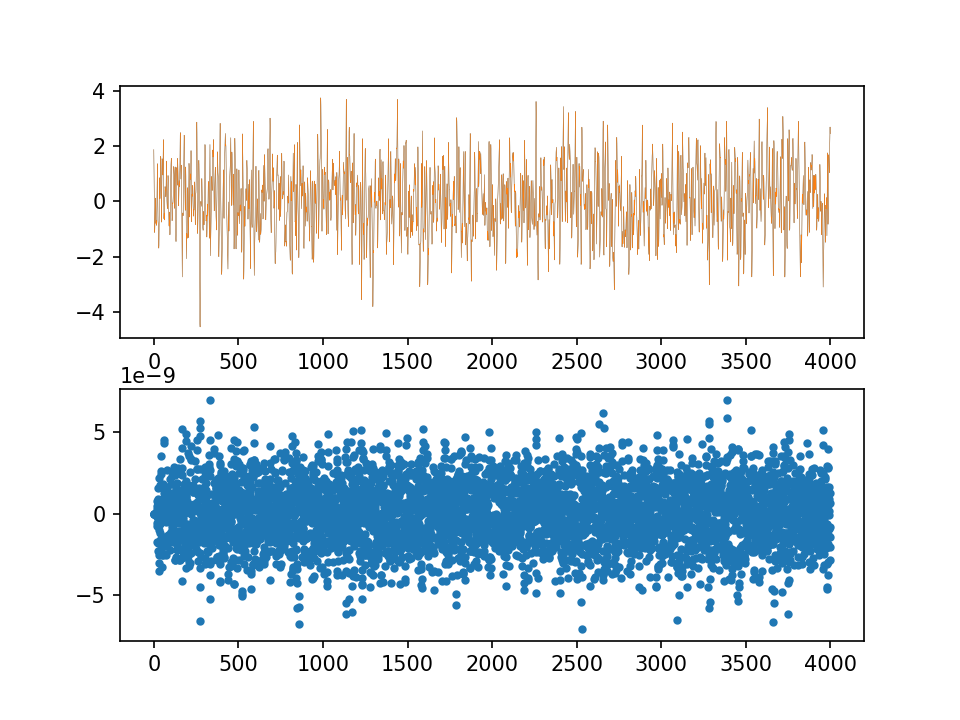

In [9]:
plt.figure()
ax=plt.subplot(211)
plt.plot(xd, yd,'-', lw=0.2)
plt.plot(xd, yd_s,'-', lw=0.2)

ax=plt.subplot(212)
plt.plot(xd, yd - yd_s,'.')

# Test low-memory sparse covariance matrix construction

See here for inspiration:
https://gist.github.com/twiecki/030aa8565bae9e7ca37e3e789b6eeead


In [10]:
def cov_on_chunked_1d(x1, x2, covfunc, covparams, threshold):
    K = covfunc(x1[:,None], x2[:,None].T, covparams)
    idx = np.abs(K)>threshold
    R,C = np.where(idx)
    return R, C, K[idx]

def create_cov_chunked(x1, x2, covfunc, covparams, threshold, chunksize, chunkedfunc):
    
    numrows = x1.shape[0]
    numcols = x2.shape[0]
    rows = []
    cols = []
    data = []
    for r in range(0, numrows+chunksize, chunksize):
        
        for c in range(0, numcols+chunksize, chunksize):
            #print(r, c, numrows)
            r1 = r + chunksize
            c1 = c + chunksize
            chunk1 = x1[r:r1]
            chunk2 = x2[c:c1]
            
            r_local, c_local, data_local = chunkedfunc(chunk1, chunk2, covfunc, covparams, threshold)
            r_global = r_local + r
            c_global = c_local + c
            
            rows.append(r_global)
            cols.append(c_global)
            data.append(data_local)
            
    return sparse.csc_matrix((np.hstack(data), (np.hstack(rows), np.hstack(cols))), 
                shape=(numrows, numcols))

    #return rows, cols, data

In [11]:
%%time
K_s2 = create_cov_chunked(xd, xd, covfunc, covparams, 1e-12, 300, cov_on_chunked_1d)
K_s2

CPU times: user 575 ms, sys: 11.1 ms, total: 586 ms
Wall time: 585 ms


<5000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 194620 stored elements in Compressed Sparse Column format>

In [12]:
%%time
# myrand = np.random.normal(size=(N,)) # Reuse this

sigI = sparse.spdiags(1e-7*np.ones(N,),0,N,N)
factor = cholesky(K_s2 + sigI)
# factor = cholesky_AAt(K_s2 + sigI)

L_s = factor.L()
yd_s = L_s.dot(myrand)

ld = factor.logdet()

CPU times: user 21.7 ms, sys: 0 ns, total: 21.7 ms
Wall time: 50.9 ms


<IPython.core.display.Javascript object>


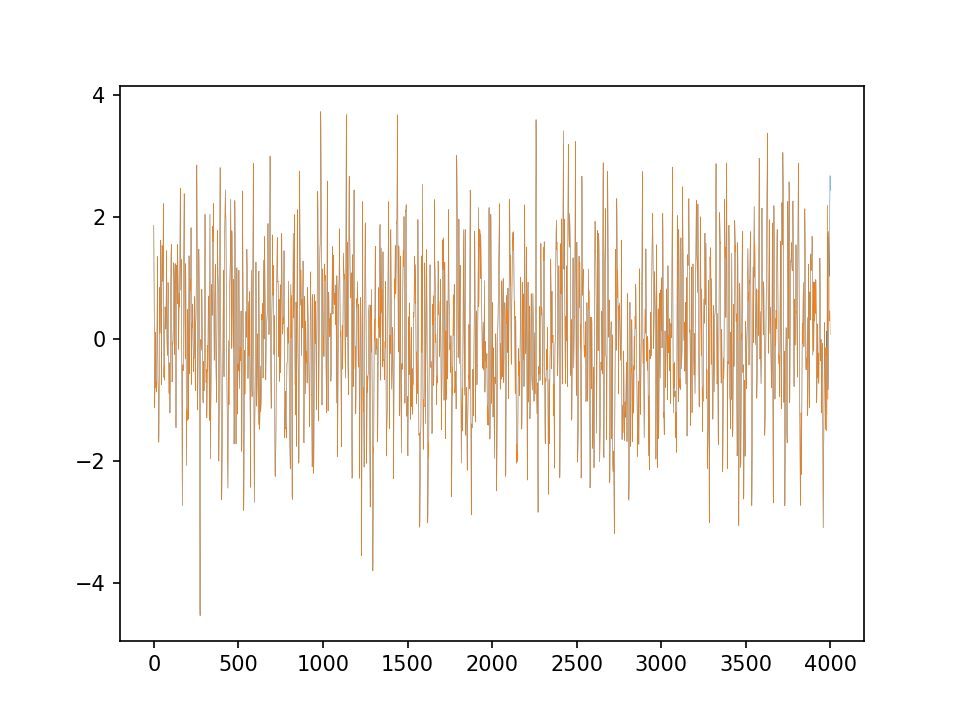

In [13]:
plt.figure()
ax=plt.subplot(111)
plt.plot(xd, yd,'-', lw=0.2)
plt.plot(xd, yd_s,'-', lw=0.2)

# plt.plot(xd, yd - yd_s,'.')

In [15]:
%%time
# Test cg solver
v = sparse.linalg.cg(K_s2 + sigI, yd)
v

CPU times: user 19.6 s, sys: 11.1 ms, total: 19.6 s
Wall time: 19.6 s


(array([  95.64315814, -444.51287642, 1069.39147379, ...,  786.13785347,
        -360.34174947,   79.98891787]),
 0)

# test the OI classes


In [14]:
from oceanoi.oi import OptimalInterp1D

In [23]:
class OptimalInterp1DSparse(OptimalInterp1D):
    """
    Optimal interpolation in one dimension (usually time)
    
    """
    
    chunksize=1000
    threshold=1e-15
    #chunkedcovfunc = cov_on_chunked_1d
    
    def __init__(self, xd, xm, sd, cov_func, cov_params, **kwargs):
        
        self.__dict__.update(kwargs)
        
        OptimalInterp1D.__init__(self, xd, xm, sd, cov_func, cov_params)
       
        
    def __call__(self, yd):
        
        assert yd.shape[0] == self.N, ' first dimension in input data must equal '
       
        #return np.dot(self.w_md.T, yd[:,:])
        return self.w_md.T.dot(yd[:,:])
        
    
    def _calc_cov(self, cov_func, cov_params):
        # Compute the covariance functions
        Kmd = create_cov_chunked(self.xm, self.xd,\
                self.cov_func, self.cov_params, self.threshold, self.chunksize, cov_on_chunked_1d)
        
        Kdd = create_cov_chunked(self.xd, self.xd,\
                self.cov_func, self.cov_params, self.threshold, self.chunksize, cov_on_chunked_1d)

        return Kmd, Kdd
    
    def _calc_weights(self, Kdd, sd, Kmd):
        # Calculate the cholesky factorization
        #L = la.cholesky(Kdd+noise+1e-7*np.eye(self.N), lower=True)

        # Compute weights matrix
        #w_md = la.cho_solve((L, True),  Kmd.T)
        
        sigI = sparse.spdiags(1e-7*np.ones(N,),0,N,N)
        noise = sparse.spdiags(sd*np.ones(N,),0,N,N)
        factor = cholesky(Kdd + noise + sigI, ordering_method='natural')
        
        #factor = cholesky(Kdd, beta=1e-7+sd , ordering_method='natural')
        #L_s = factor.L()
        
        #w_md = factor.solve_A(Kmd.T)
        #w_md = factor.solve_L(self.Kmd.T, use_LDLt_decomposition=False)
        w_tmp = factor.solve_L(self.Kmd.T, use_LDLt_decomposition=False)
        w_md = factor.solve_Lt(w_tmp, use_LDLt_decomposition=False)
        
        return factor, w_md


    def calc_err(self, diag=True):
        Kmm = self.cov_func(self.xm[:,None], self.xm[:,None].T, self.cov_params)
        Kdm = self.cov_func(self.xd[:,None], self.xm[:,None].T, self.cov_params)
        
        Kmm = create_cov_chunked(self.xm, self.xm,\
                self.cov_func, self.cov_params, self.threshold, self.chunksize, cov_on_chunked_1d)
        
        Kdm = create_cov_chunked(self.xd, self.xm,\
                self.cov_func, self.cov_params, self.threshold, self.chunksize, cov_on_chunked_1d)
        
        V = Kmm - self.w_md.T.dot(Kdm)

        if diag:
            return V.diagonal()
        else:
            return V
        
    def sample_posterior(self, yd, samples):
        
        # Predict the mean
        ymu = self.__call__(yd)

        # Predict the covariance
        Σ = self.calc_err(diag=False)

        return np.random.multivariate_normal(ymu.ravel(), Σ, samples)
    
    def sample_prior(self, samples):
        
        #return np.random.multivariate_normal(np.zeros((self.N,)), self.Kdd, samples)
        myrand = np.random.normal(size=(N,samples)) 
        return self.L.L().dot(myrand)

    
    def log_marg_likelihood(self, yd):
        
        #logdet = 2*np.sum(np.log(np.diagonal(self.L)))
        logdet = 2*self.L.logdet()
        
        #v = la.cho_solve((self.L, True), yd )
        v_tmp = self.L.solve_L(yd, use_LDLt_decomposition=False)
        v = self.L.solve_Lt(v_tmp, use_LDLt_decomposition=False)
        #v = self.L.solve_A(yd)
        
        qdist = np.dot(yd.T, v)[0,0]
        
        fac = self.N * np.log(2*np.pi)
        
        return -0.5*(logdet + qdist + fac)
        
    def print_matrix_sizes(self):
        sizestr = 'N = {}, M = {}\n----'.format(self.N, self.M)
        sizestr += '\n\tKdd = {} ({} MB)'.format(self.Kdd.nnz, self.Kdd.nnz*8/1e6)
        sizestr += '\n\tKmd = {} ({} MB)'.format( self.Kmd.nnz, self.Kmd.nnz*8/1e6)
        sizestr += '\n\tw_md [{}, {}] = {} ({} MB)'.format(self.w_md.shape[0], self.w_md.shape[1],
                                        self.w_md.nnz, self.w_md.nnz*8/1e6)

        print(sizestr)
            

In [29]:
%%time
OI = oi.OptimalInterp1D(xd, xo, noise, covfunc, covparams)



CPU times: user 33.4 s, sys: 3.08 s, total: 36.5 s
Wall time: 13.8 s


In [30]:
yo = OI(yd[:,None])[:,0]

#yo_var = OI.calc_err(diag=True)


In [24]:
%%time
OIs = OptimalInterp1DSparse(xd, xo, noise, covfunc, covparams, chunksize=500, threshold=1e-21)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:52: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format


CPU times: user 8.93 s, sys: 363 ms, total: 9.29 s
Wall time: 9.28 s


In [25]:
%%time
yos = OIs(yd[:,None])[:,0]
#yos_var = OIs.calc_err(diag=True)

CPU times: user 119 ms, sys: 2.75 ms, total: 122 ms
Wall time: 120 ms


In [26]:
ytst = OIs.sample_prior(1)

In [44]:
# Print out matrix sizes
self = OIs
sizestr = 'N = {}, M = {}\n----'.format(self.N, self.M)
sizestr += '\n\tKdd = {} ({} MB)'.format(self.Kdd.nnz, self.Kdd.nnz*8/1e6)
sizestr += '\n\tKmd = {} ({} MB)'.format( self.Kmd.nnz, self.Kmd.nnz*8/1e6)
sizestr += '\n\tw_md [{}, {}] = {} ({} MB)'.format(self.w_md.shape[0], self.w_md.shape[1],
                                self.w_md.nnz, self.w_md.nnz*8/1e6)

print(sizestr)

N = 5000, M = 25000
----
	Kdd = 254350 (2.0348 MB)
	Kmd = 1287991 (10.303928 MB)
	w_md [5000, 25000] = 105973021 (847.784168 MB)


<IPython.core.display.Javascript object>


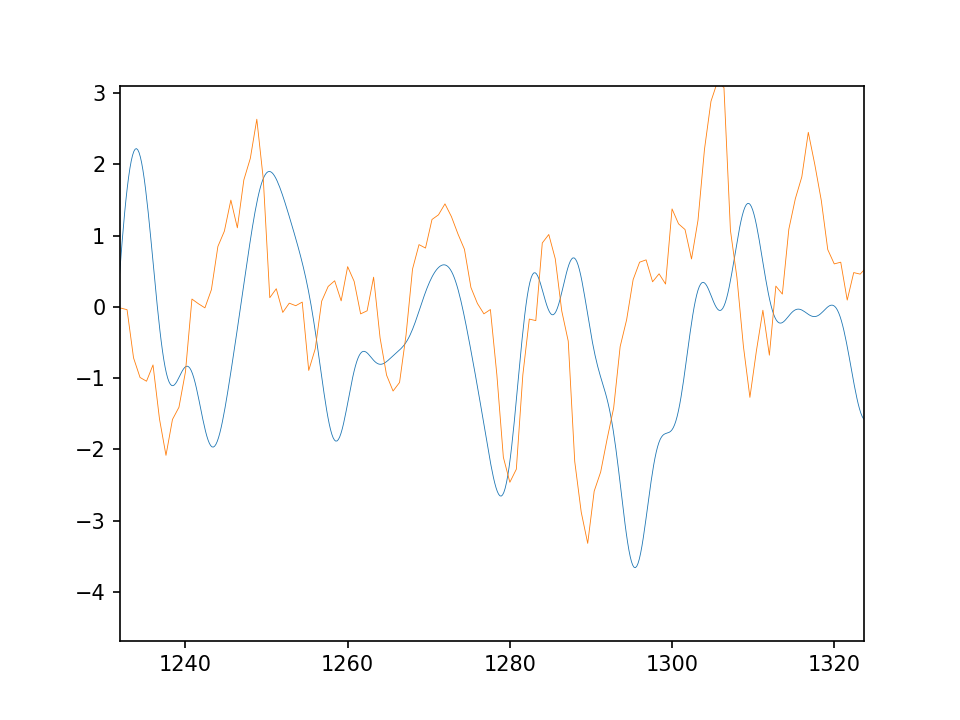

In [28]:
plt.figure()
# plt.plot(xd, yd,'.',ms=1)
# plt.plot(xo, yo, lw=0.4)
plt.plot(xo, yos, lw=0.4)
plt.plot(xd, ytst, lw=0.4)

# plt.fill_between(xo, y1=yo-2*yo_var, y2=yo+2*yo_var, alpha=0.2)
# plt.fill_between(xo, y1=yos-2*yos_var, y2=yos+2*yos_var, alpha=0.2)


In [91]:
OI.log_marg_likelihood(yd[:,None]), OIs.log_marg_likelihood(yd[:,None])

(626.7469523339287, 282.5987424249415)

In [92]:
2*np.sum(np.log(np.diagonal(OI.L))), 2*OIs.L.logdet(), 2*np.sum(np.log(OIs.L.D()))

(-12677.80329507896, -11528.03394611221, -11528.03394611221)

In [23]:
%%time
sigI = sparse.spdiags(1e-7*np.ones(N,),0,N,N)
noise = sparse.spdiags(OI.sd*np.ones(N,),0,N,N)

# 
#w_md = sparse.linalg.spsolve(K_s + noiseI + sigI, OIs.Kmd.T.tocsc())
#w_md
lu = sparse.linalg.splu(K_s + noiseI + sigI)
w_md = lu.solve(OIs.Kmd.T)

NameError: name 'noiseI' is not defined

In [24]:
L = OIs.L.L()
w_md = sparse.linalg.spsolve(L, OIs.Kmd.T)
w_md

/opt/tljh/user/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:216: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


<5000x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 50575309 stored elements in Compressed Sparse Column format>

In [25]:
%%time
# w_tmp = OIs.L.solve_L(OIs.Kmd.T, use_LDLt_decomposition=False)
# w_md = OIs.L.solve_L(w_tmp, use_LDLt_decomposition=False)

w_tmp = OIs.L.solve_L(OIs.Kmd.T, use_LDLt_decomposition=False)
w_md = OIs.L.solve_Lt(w_tmp, use_LDLt_decomposition=False)
#w_md = OIs.L.solve_A(OIs.Kmd.T) # This returns a dense matrix


# w_md = OIs.L.solve_Lt(OIs.Kmd.T, use_LDLt_decomposition=False)

# w_md = OIs.L.solve_LD(OIs.Kmd.T)
# w_md = OIs.L.solve_DLt(OIs.Kmd.T)


# w_md = Ltmp.dot(Ltmp.T)
w_md

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  after removing the cwd from sys.path.


CPU times: user 4.42 s, sys: 441 ms, total: 4.86 s
Wall time: 4.85 s


<5000x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 105884255 stored elements in Compressed Sparse Column format>

In [26]:
%%time
yos = w_md.T.dot(yd[:,None])


plt.figure()
# plt.plot(xd, yd,'.',ms=1)
#plt.fill_between(xo, y1=yo-2*yo_var, y2=yo+2*yo_var, alpha=0.2)
plt.plot(xo, yo)
plt.plot(xo, yos)

<IPython.core.display.Javascript object>

CPU times: user 191 ms, sys: 4.76 ms, total: 196 ms
Wall time: 191 ms


In [27]:
OI.log_marg_likelihood(yd[:,None])

626.7469523339287